# 병합된 데이터로 CNN-LSTM 훈련

In [22]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager

import warnings
warnings.filterwarnings('ignore')

In [2]:
model = tf.keras.Sequential()

## CNN layers 정의

In [3]:
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 24, 5))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))

## LSTM layers 정의

In [4]:
model.add(Bidirectional(LSTM(6, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(6, return_sequences=False)))
model.add(Dropout(0.5))

## Final layers

In [5]:
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

## 훈련할 데이터 load, 입력에 맞게 변환(window_size=24)

In [6]:
def data_transform(name,time_steps):
    data=pd.read_csv("../Merged_Data/{:s}.csv".format(name))
    
    if name.split("_")[-1]=='x':
        sequences=[]
        for i in range(len(data) - time_steps + 1):
            sequence = data[i:i+time_steps]
            sequences.append(sequence)
        return np.array(sequences)
    
    return np.array(data[23:])

In [ ]:
train_x=data_transform('train_x',24)
train_y=data_transform('train_y',24)
test_x=data_transform('test_x',24)
test_y=data_transform('test_y',24)
valid_x=data_transform('valid_x',24)
valid_y=data_transform('valid_y',24)

In [8]:
train_x = train_x.reshape(train_x.shape[0],1,24,5)
valid_x = valid_x.reshape(valid_x.shape[0],1,24,5)
test_x = test_x.reshape(test_x.shape[0],1,24,5)

In [9]:
print(train_x.shape)
print(test_x.shape)

(55204, 1, 24, 5)
(3046, 1, 24, 5)


## 하이퍼 파라미터 정의

In [ ]:
batch_size = 1
time_steps = 24
feature_num = 5

## 모델 훈련(epoch=100)

In [10]:
history = model.fit(train_x, train_y,
                    validation_data=(valid_x, valid_y),
                    batch_size=batch_size, epochs=100)

Epoch 1/100
55204/55204 [==============================] - 128s 2ms/step - loss: 0.0274 - mse: 0.0274 - mae: 0.1234 - val_loss: 0.0175 - val_mse: 0.0175 - val_mae: 0.1024
Epoch 2/100
55204/55204 [==============================] - 128s 2ms/step - loss: 0.0230 - mse: 0.0230 - mae: 0.1121 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.0851
Epoch 3/100
55204/55204 [==============================] - 122s 2ms/step - loss: 0.0221 - mse: 0.0221 - mae: 0.1096 - val_loss: 0.0154 - val_mse: 0.0154 - val_mae: 0.0886
Epoch 4/100
55204/55204 [==============================] - 117s 2ms/step - loss: 0.0217 - mse: 0.0217 - mae: 0.1085 - val_loss: 0.0153 - val_mse: 0.0153 - val_mae: 0.0849
Epoch 5/100
55204/55204 [==============================] - 118s 2ms/step - loss: 0.0213 - mse: 0.0213 - mae: 0.1074 - val_loss: 0.0145 - val_mse: 0.0145 - val_mae: 0.0836
Epoch 6/100
55204/55204 [==============================] - 118s 2ms/step - loss: 0.0212 - mse: 0.0212 - mae: 0.1070 - val_loss: 0.0144 - val_mse:

## 모델 저장, test set 예측 결과 확인

In [ ]:
model.save('./Saved_Model/CNN-LSTM(epoch=100).pt')

test_predict = model.predict(test_x, batch_size)

## sclaer를 불러와서 inverse transform 적용

In [15]:
import joblib
scaler = joblib.load('../Merged_Data/Scaler/Y_pm10.pkl')

inv_test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
inv_test_predict = scaler.inverse_transform(test_predict)

c:\Users\heeji\anaconda3\envs\meta2\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


## 성능 평가 : SMAPE

In [18]:
def Symmetric_mean_absolute_percentage_error(actual, predicted):
    
    total=len(actual)
    numerator=np.abs(actual-predicted)
    denominator=np.abs(actual)+np.abs(predicted)
    SMAPE=(100/total)*np.sum(numerator/denominator)
    
    return SMAPE

In [19]:
test_smape = Symmetric_mean_absolute_percentage_error(inv_test_y, inv_test_predict)
print("Test SMAPE: %.2f" % test_smape)

Test SMAPE: 16.78


## 결과 시각화

In [20]:
def vizualization_self(train_term,name,test_y,pred_y):
    plt.figure(figsize=(32, 16))
    
    plt.plot(np.arange(train_term), test_y[:train_term], color='red', ls='-', lw=3, label='Raw Data')
    plt.plot(np.arange(train_term), pred_y[:train_term], color='blue', ls='--', lw=3, label='Raw Data')
    
    plt.xlabel('[Time]', fontsize=25, fontweight='bold')
    plt.ylabel('[PM10]', fontsize=25, fontweight='bold')
    plt.title('Prediction Visualization({:s})'.format(name),fontsize=30, weight='bold')
    plt.xticks( fontsize=15, fontweight='bold')
    plt.yticks( fontsize=15, fontweight='bold')
    plt.grid(True)
    plt.legend()
    return

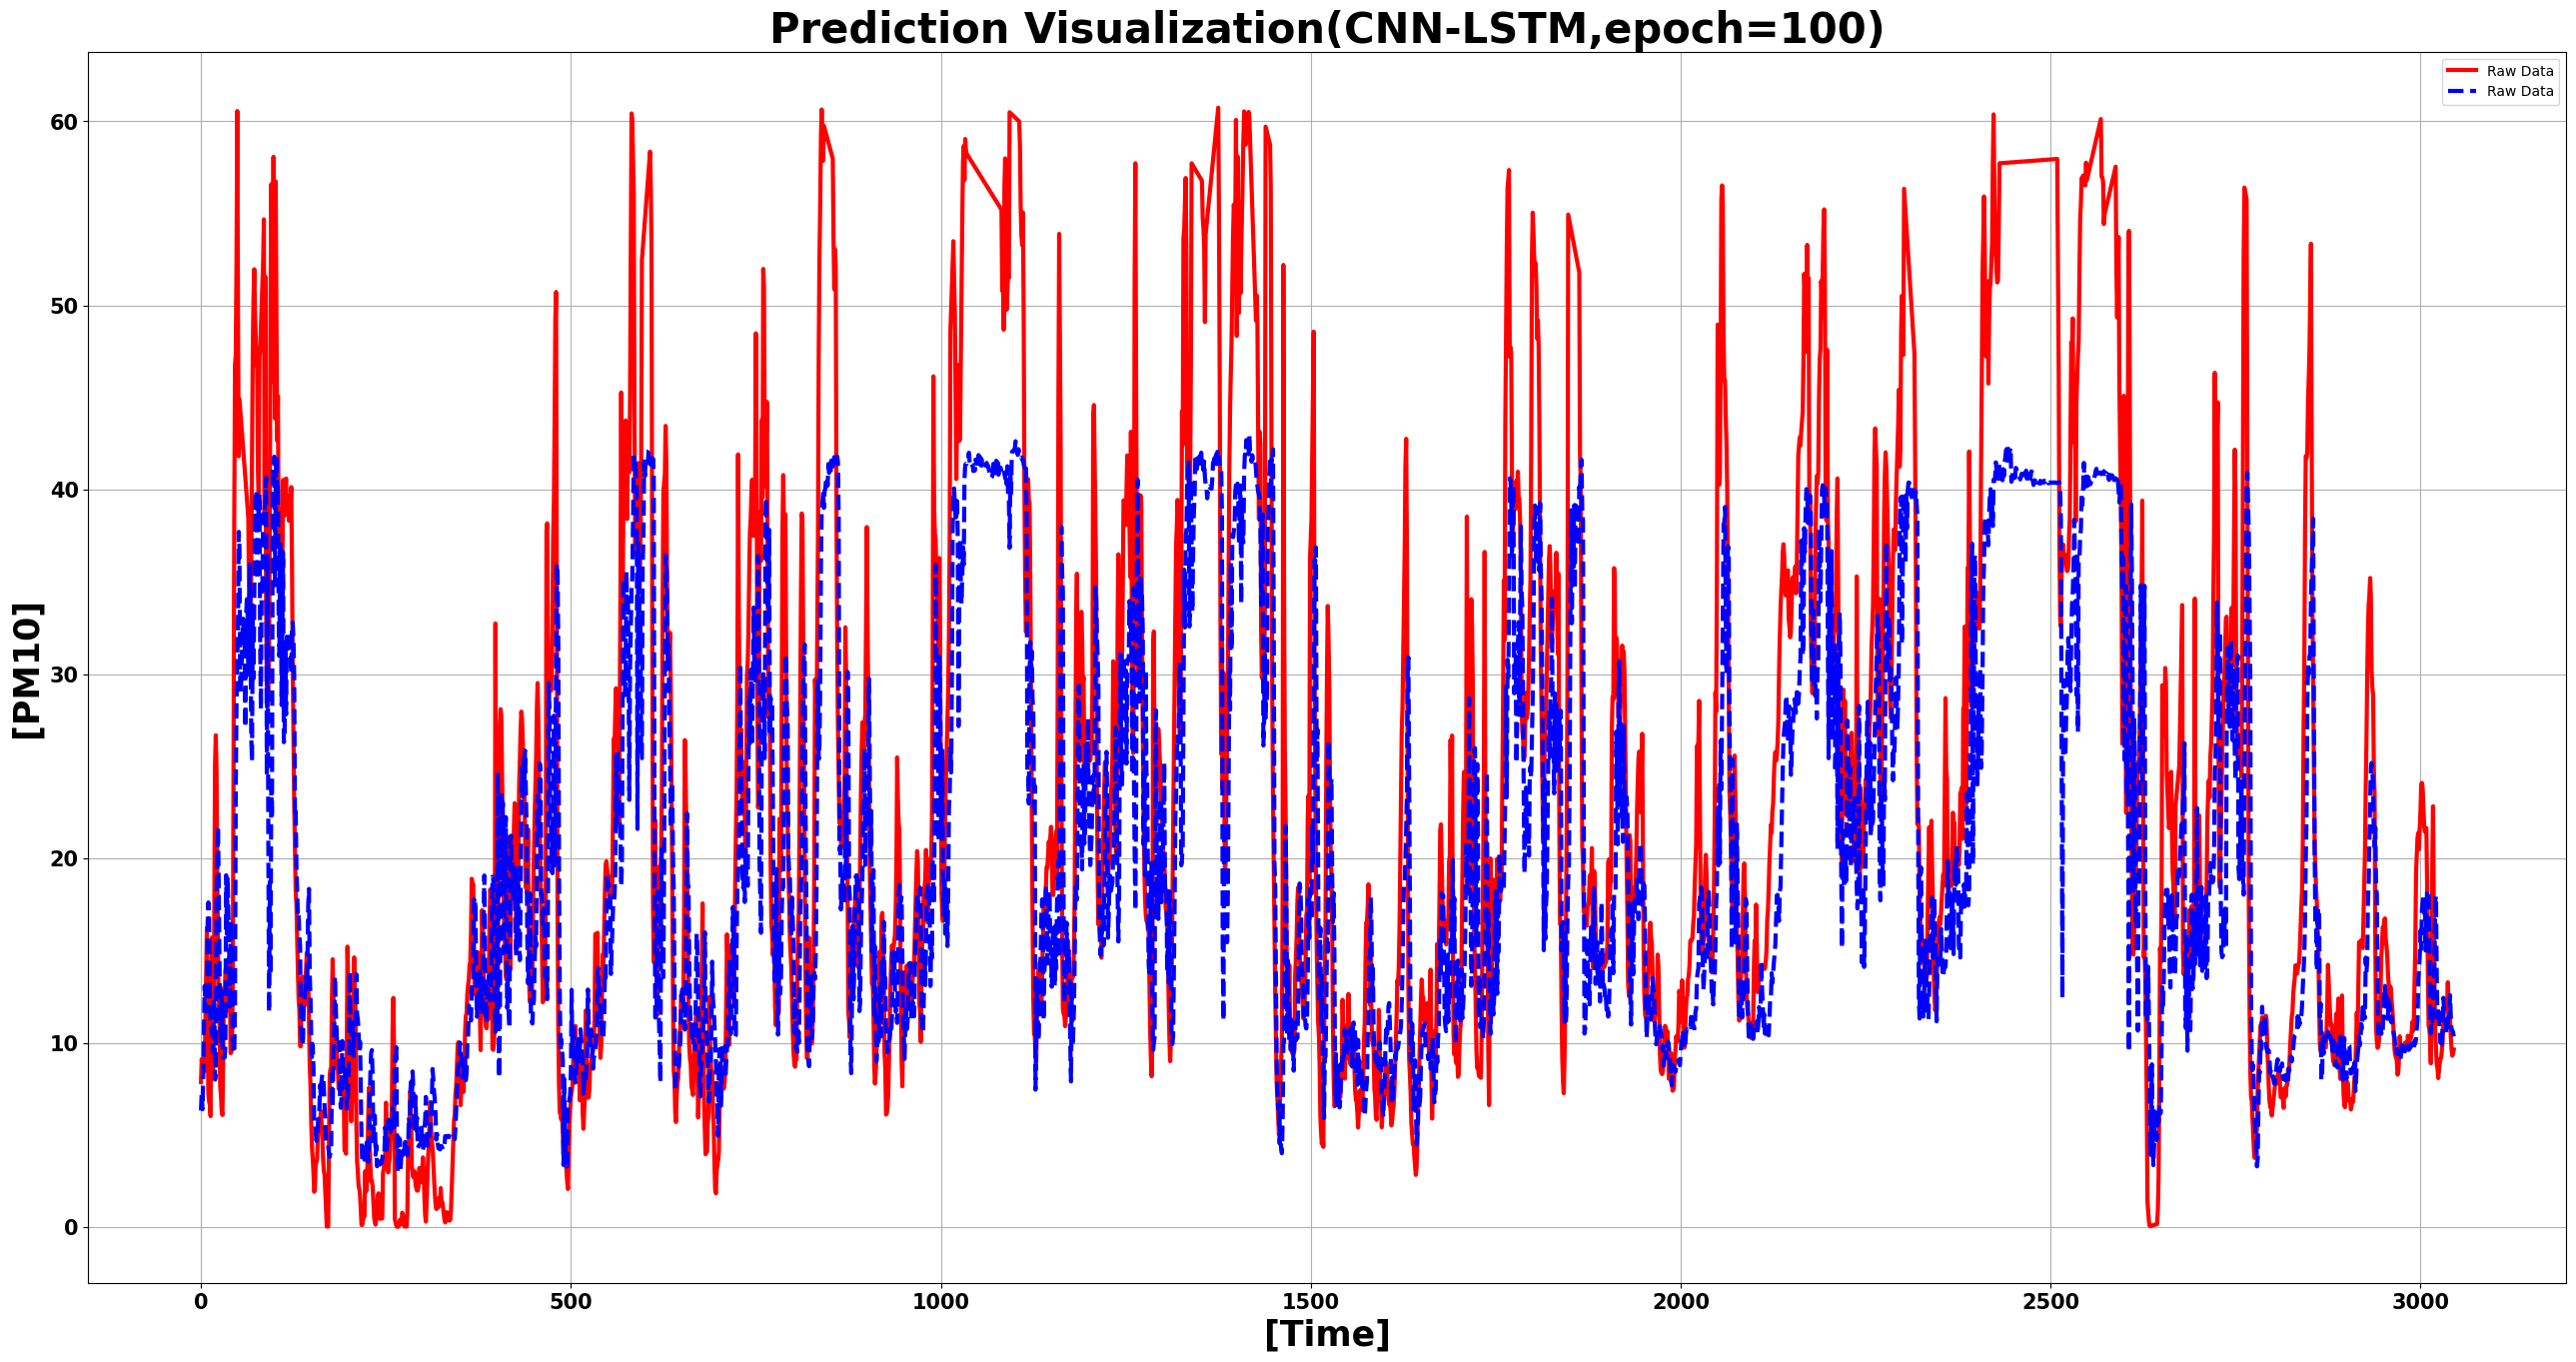

In [23]:
vizualization_self(len(inv_test_y),'CNN-LSTM,epoch=100',inv_test_y,inv_test_predict)

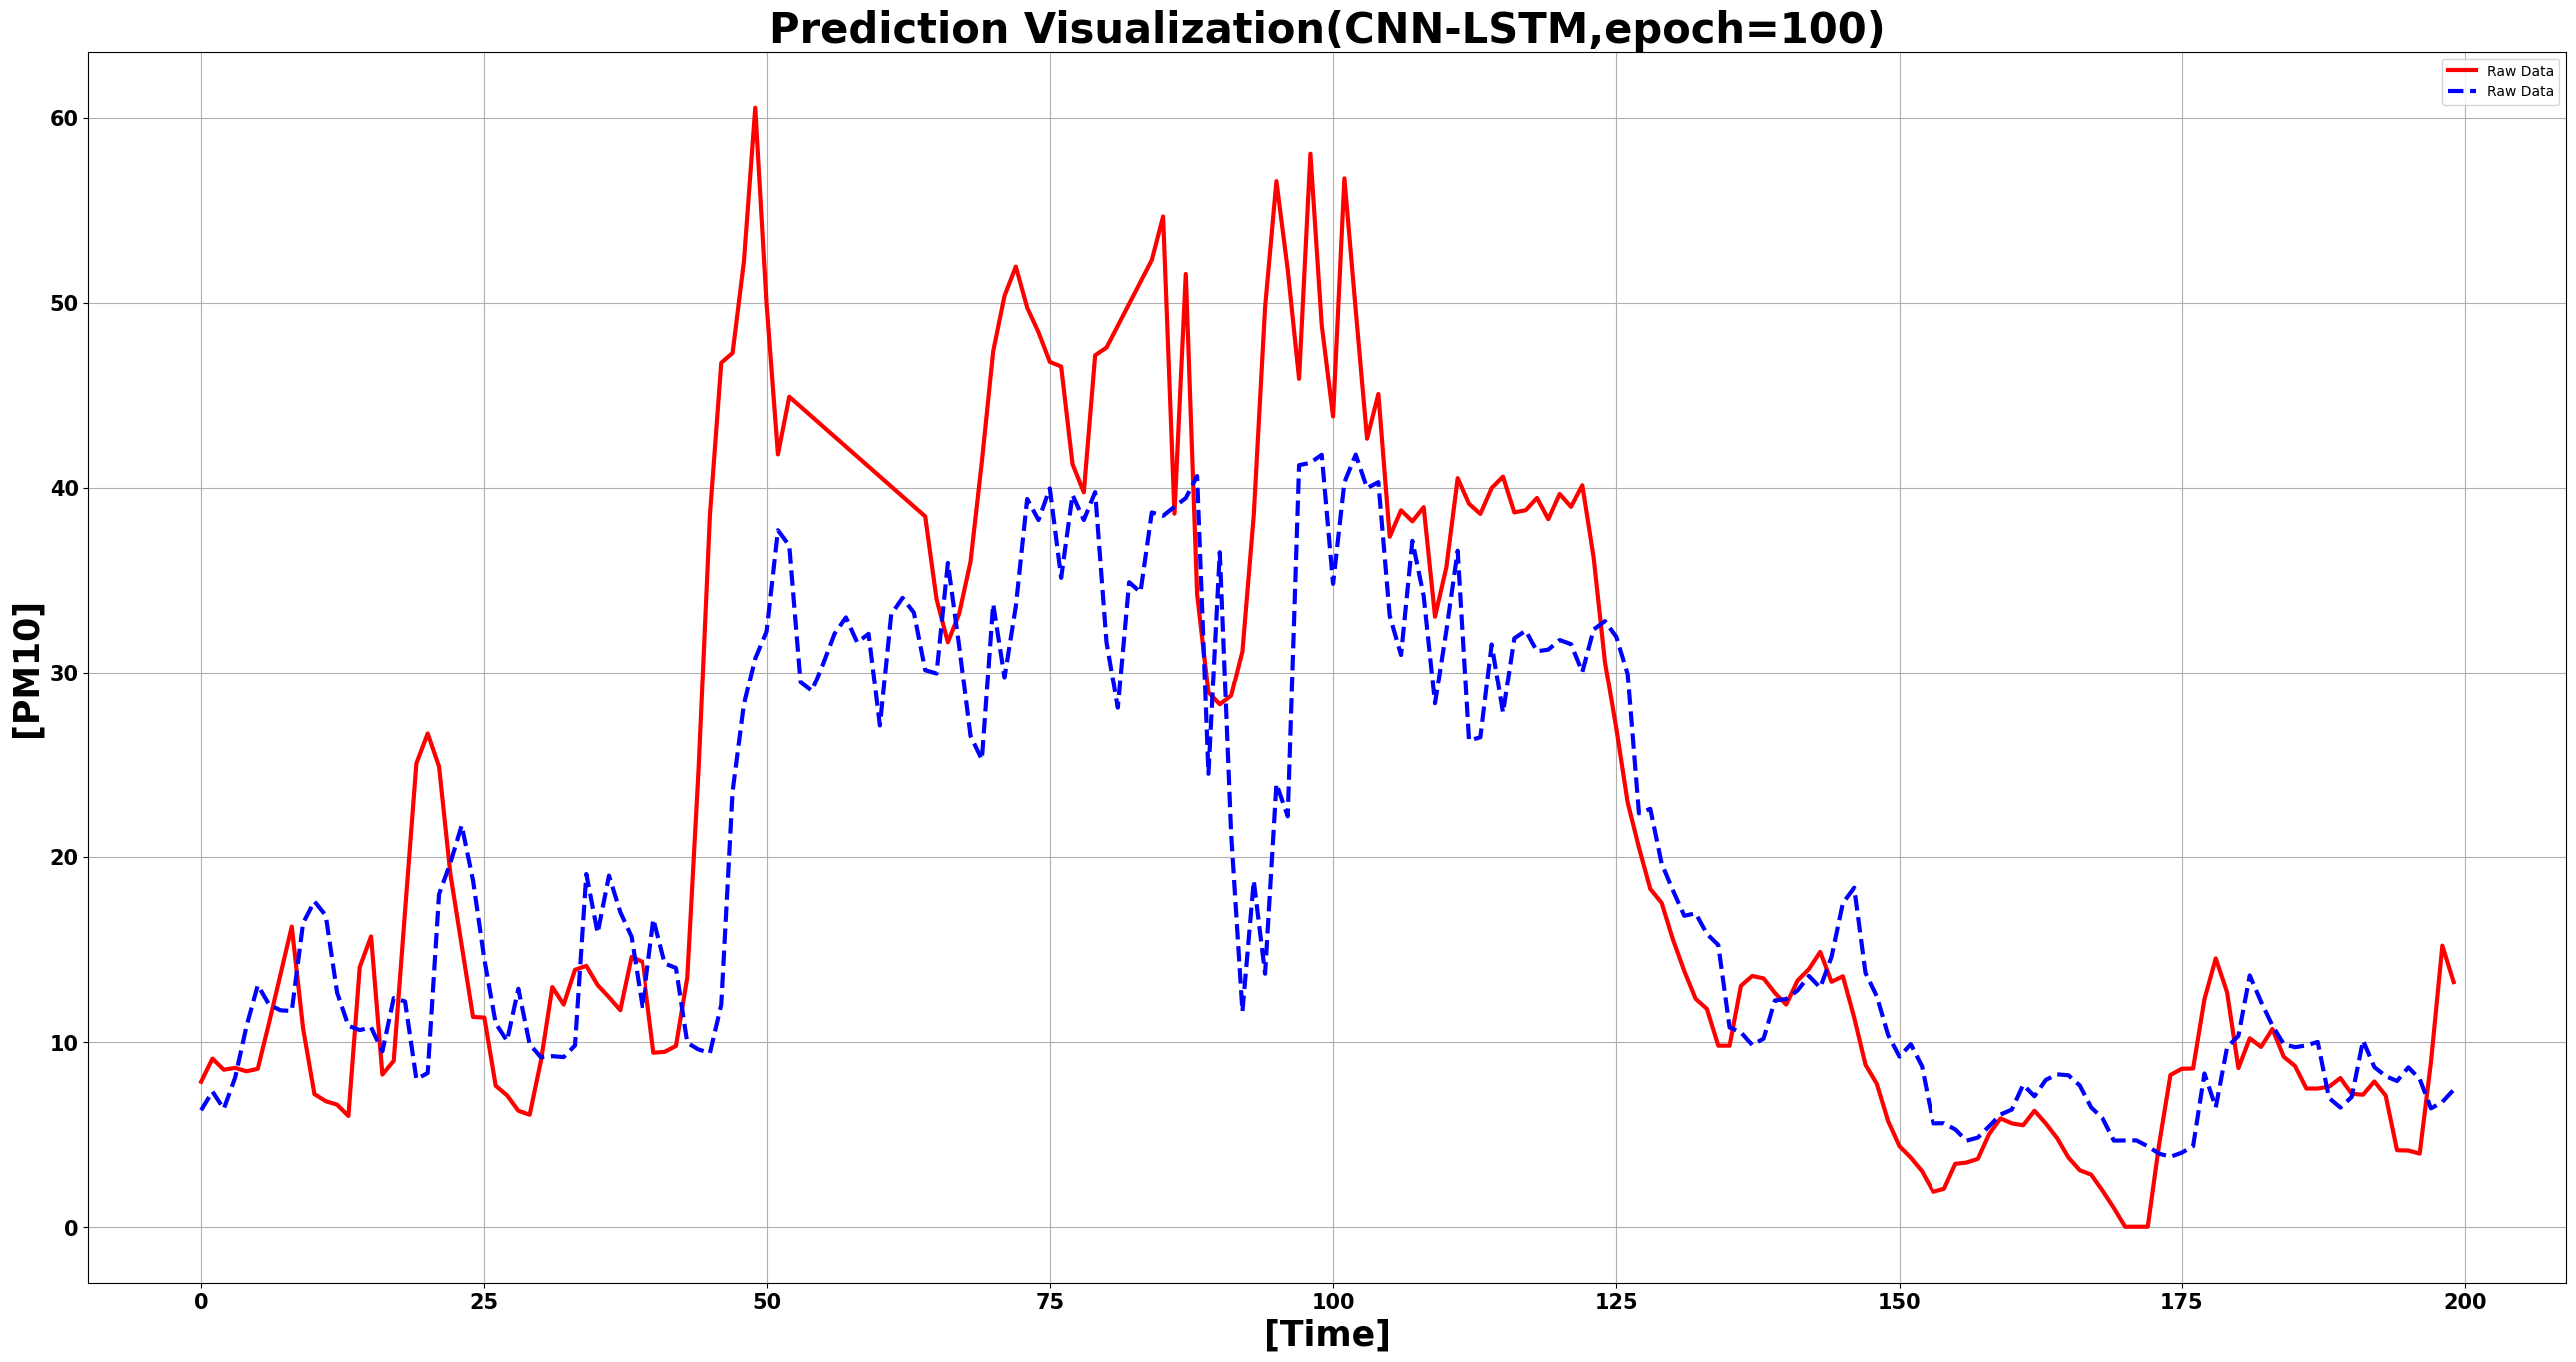

In [24]:
vizualization_self(200,'CNN-LSTM,epoch=100',inv_test_y,inv_test_predict)